# Data
Download the IMDB reviews if its not already in the local cache.
Load from the local cache and split to train and test sets.

In [1]:
import os
import ssl
from tensorflow.keras.utils import get_file
try:
    from notebooks.data import load_imdb
except ModuleNotFoundError:
    from data import load_imdb

if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context
    
zip_file = get_file('aclImdb.zip', origin='http://mng.bz/0tIo', extract=True)
imdb_dir = zip_file.replace('.zip', '')
(train_texts, train_labels), (test_texts, test_labels) = load_imdb(imdb_dir)

print('An example from the reviews:')
print('============================')
print(f'Text : {train_texts[0][:200]}...')
print(f'Label: {train_labels[0]}')

An example from the reviews:
Text : Entertainment Tonight has been going down hill for the last few years, but as of last night (Aug 17th 2006) they reached a new low.<br /><br />In an effort to try to hype up their broadcast, they deci...
Label: neg


# Prepare Data
Initialize a `SentWordVectorizer`. The vectorizer will be fitted on the 
`train_texts`. We will use a simple sentence tokenizer and a simple 
word tokenizer,  so the words will be split on spaces. The vocabulary is 
restricted to  `num_words` words.

In [2]:
from keras_nlp.preprocessing import sent_tokenize, word_tokenize
from keras_nlp import SentWordVectorizer

num_words = 50000
sent_word_vectorizer = SentWordVectorizer(
    sent_tokenize, num_words=num_words, oov_token='UNK')
sent_word_vectorizer.fit_on_texts(train_texts)
# The vectorizer's number of tokens num_words + PAD + OOV token
print(f'Vectorizer number of tokens: {sent_word_vectorizer.num_tokens}')

2020-Apr-09 23:49:59 [INFO    :SentWordVectorizer] - Creating vocabulary.


25000/25000 [==============================] - 4s 165us/step
Vectorizer number of tokens: 50002


## Encode Labels
The labels are strings ('pos' / 'neg'). We will convert them to numbers.

In [3]:
from sklearn.preprocessing import label_binarize

y_train = label_binarize(train_labels, classes=['neg', 'pos'])
y_test = label_binarize(test_labels, classes=['neg', 'pos'])

## Keep a Validation Set

In [4]:
from sklearn.model_selection import train_test_split

train_texts, val_texts, y_train, y_val = train_test_split(
    train_texts, y_train, stratify=train_labels, shuffle=True, random_state=45)

## Create Generators for Vectorized Data
We use the `texts_to_vectors_generator` method. The generator expects the 
texts, the labels and other parameters such as `shape` and `batch_size`.
For the `shape` we define to be `max_sentences, max_tokens`, where 
`max_sentences` apply to the text and `max_tokens` to the sentences.

**Attention**: We *must* pass the same number of `max_sentences` and 
`max_tokens` when converting different text sets (train, validation, test). 
If we don't, then it is almost certain that the results will have different 
numbers of columns because the set are likely to have different number of tokens.

In [5]:
batch_size = 50
max_sentences, max_tokens = 10, 15
train_generator = sent_word_vectorizer.texts_to_vectors_generator(
    train_texts, y_train, shape=(max_sentences, max_tokens), batch_size=batch_size)
val_generator = sent_word_vectorizer.texts_to_vectors_generator(
    val_texts, y_val, shape=(max_sentences, max_tokens), batch_size=batch_size)

# Neural Network
Here we define a toy network for demonstration purpose.
The model has two layers. The first encodes the words of a sentence providing 
sentence vectors. The second encodes the sentence
vectors to a document vector.

## Word Encoder Model
You might want to use an Attention layer instead of a Flatten in both 
`word_model` and `model`.

In [6]:
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Embedding, TimeDistributed, \
    Dropout, Flatten, Dense, Bidirectional, LSTM

rnn_params = dict(dropout=0.2, return_sequences=True, recurrent_dropout=0.2)

words_input = Input(shape=(max_tokens, ), name='Words_Input', dtype='int32')
words_embeddings = Embedding(
    input_dim=sent_word_vectorizer.num_tokens,
    output_dim=100,
    input_length=max_tokens,
    mask_zero=False,
    trainable=True,
    name='Embeddings')(words_input)
words_encoder = Bidirectional(
    LSTM(100, **rnn_params), name='Words_Encoder')(words_embeddings)
x = Flatten(name='Flatten')(words_encoder)
word_model = Model(words_input, x)

print(word_model.summary(line_length=90))

Model: "model"
__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
Words_Input (InputLayer)                [(None, 15)]                        0             
__________________________________________________________________________________________
Embeddings (Embedding)                  (None, 15, 100)                     5000200       
__________________________________________________________________________________________
Words_Encoder (Bidirectional)           (None, 15, 200)                     160800        
__________________________________________________________________________________________
Flatten (Flatten)                       (None, 3000)                        0             
Total params: 5,161,000
Trainable params: 5,161,000
Non-trainable params: 0
__________________________________________________________________________________________

## Sentence Encoder Model

In [7]:
sent_input = Input(
    shape=(max_sentences, max_tokens), dtype='int32', name='Sent_Input')
sent_input_over_word_model = TimeDistributed(
    word_model, name='Word_Model')(sent_input)
sent_encoder = Bidirectional(
    LSTM(100, **rnn_params), name='Sents_Encoder')(sent_input_over_word_model)
x = Dropout(0.3, name='Dropout')(sent_encoder)
x = Flatten(name='Flatten')(x)
predictions = Dense(1, activation='sigmoid', name='Predictions')(x)
model = Model(sent_input, predictions)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

print(model.summary(line_length=90))

Model: "model_1"
__________________________________________________________________________________________
Layer (type)                            Output Shape                        Param #       
Sent_Input (InputLayer)                 [(None, 10, 15)]                    0             
__________________________________________________________________________________________
Word_Model (TimeDistributed)            (None, 10, 3000)                    5161000       
__________________________________________________________________________________________
Sents_Encoder (Bidirectional)           (None, 10, 200)                     2480800       
__________________________________________________________________________________________
Dropout (Dropout)                       (None, 10, 200)                     0             
__________________________________________________________________________________________
Flatten (Flatten)                       (None, 2000)                     

## Train Model

In [8]:
train_steps_per_epoch = len(train_texts) // batch_size
if train_steps_per_epoch % batch_size:
    train_steps_per_epoch += 1
val_steps_per_epoch = len(val_texts) // batch_size
if val_steps_per_epoch % batch_size:
    val_steps_per_epoch += 1

history = model.fit(x=train_generator,
                    steps_per_epoch=train_steps_per_epoch,
                    validation_data=val_generator,
                    validation_steps=val_steps_per_epoch,
                    epochs=5)

  ...
    to  
  ['...']


2020-Apr-09 23:50:54 [WARNING :tensorflow  ] - sample_weight modes were coerced from
  ...
    to  
  ['...']


  ...
    to  
  ['...']


2020-Apr-09 23:50:54 [WARNING :tensorflow  ] - sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 376 steps, validate for 126 steps
Epoch 1/5
376/376 [==============================] - 80s 214ms/step - loss: 0.4322 - acc: 0.7911 - val_loss: 0.3733 - val_acc: 0.8330
Epoch 2/5
376/376 [==============================] - 66s 176ms/step - loss: 0.2451 - acc: 0.9011 - val_loss: 0.3949 - val_acc: 0.8497
Epoch 3/5
376/376 [==============================] - 64s 169ms/step - loss: 0.1609 - acc: 0.9365 - val_loss: 0.4313 - val_acc: 0.8473
Epoch 4/5
376/376 [==============================] - 67s 177ms/step - loss: 0.0978 - acc: 0.9645 - val_loss: 0.5387 - val_acc: 0.8471
Epoch 5/5
376/376 [==============================] - 66s 175ms/step - loss: 0.0521 - acc: 0.9823 - val_loss: 0.8703 - val_acc: 0.8157


## Model Evaluation

In [9]:
import numpy as np
from sklearn.metrics import classification_report

steps = len(test_texts) // batch_size
if len(test_texts) % batch_size:
    steps += 1
test_generator = sent_word_vectorizer.texts_to_vectors_generator(
    test_texts, y_test, shape=(max_sentences, max_tokens,), batch_size=batch_size)
predictions = model.predict(test_generator, steps=steps, verbose=1)
y_pred = np.round(predictions)
print(classification_report(
    y_test, y_pred, digits=4, target_names=['neg', 'pos']))


500/500 [==============================] - 26s 52ms/step
              precision    recall  f1-score   support

         neg     0.7555    0.9074    0.8245     12500
         pos     0.8840    0.7063    0.7853     12500

    accuracy                         0.8068     25000
   macro avg     0.8198    0.8068    0.8049     25000
weighted avg     0.8198    0.8068    0.8049     25000



# Plot Accuracy and Loss

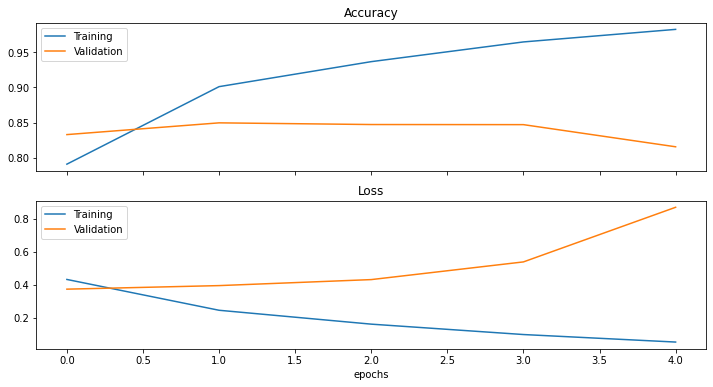

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline

_, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(12, 6))
ax1.plot(history.epoch, history.history['acc'], label='Training')
ax1.plot(history.epoch, history.history['val_acc'], label='Validation')
ax1.set_title('Accuracy')
ax1.legend()

ax2.plot(history.epoch, history.history['loss'], label='Training')
ax2.plot(history.epoch, history.history['val_loss'], label='Validation')
ax2.set_title('Loss')
ax2.set_xlabel('epochs')
ax2.legend()

plt.show()